In [1]:
import numpy as np
import os, shutil
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from MusicData import MusicData

# input parameters
x_len = 80
y_len = 40
batch_size = 32
n_samples = 4096
# LSTM parameters
num_layers = 2
lstm_size = 50
dropout_prob = 0.2
# training parameters
num_epochs = 100
epoch_size = 4096
verbose = True
display_interval = 500
moving_avg_length = 100
learn_rate = 0.001
momentum = 0.8
step_size = 50
gamma = 0.5

# fix random seed for reproducibility
np.random.seed(7)

## Load data

Sample rate: 44100


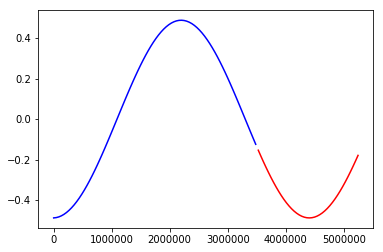

In [2]:
# filelist = ['a2002011001-e02.wav']
filelist = ['sine.wav']
music_data = MusicData(filelist, x_len, y_len)
x_ex, y_ex = music_data.__getitem__(0)

print('Sample rate: {}'.format(music_data.sample_rate))
x_duration = music_data.sample_rate * len(x_ex)
x = np.linspace(0, x_duration, len(x_ex), endpoint=False)
y_duration = music_data.sample_rate * len(y_ex) + x_duration
y = np.linspace(x_duration, y_duration, len(y_ex), endpoint=False)

plt.plot(x, x_ex, 'b')
plt.plot(y, y_ex, 'r')
plt.show()

## Make DataLoader

In [3]:
dataloader = DataLoader(music_data, batch_size=4, shuffle=True, num_workers=4)

## Build model

In [4]:
class MusicRNN(nn.Module):
    def __init__(self, x_len, y_len, num_layers=1, hidden_nodes=50, dropout=0.0):
        super().__init__()
        self.x_len = x_len
        self.y_len = y_len
        self.num_layers = num_layers
        self.dropout = dropout
                
        # define net parameters
        self.rnn = nn.LSTM(x_len, hidden_nodes, num_layers=num_layers, dropout=dropout)    
        self.hidden_nodes = self.init_hidden(hidden_nodes)
        self.ln1 = nn.Linear(hidden_nodes, y_len)
        
    def init_hidden(self, hidden_nodes):
        return (torch.zeros(1, 1, hidden_nodes),
                torch.zeros(1, 1, hidden_nodes))
        
    def forward(self, x):
        x, self.hidden_nodes = self.rnn(x, self.hidden)
        x = self.ln1(x)
        return x


In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

rnn_model = MusicRNN(x_len, y_len, num_layers=num_layers, hidden_nodes=lstm_size, dropout=dropout_prob)

rnn_model = rnn_model.to(device)

criterion = nn.MSELoss()

optimizer = torch.optim.RMSprop(rnn_model.parameters(), lr=learn_rate, momentum=momentum)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

/home/masonmcgough/anaconda2/envs/PyTorchSIIM/lib/python3.6/site-packages/torch/cuda/__init__.py:116: UserWarning: 
    Found GPU0 Quadro K4000 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


NameError: name 'optim' is not defined

## Define training

## More complex RNN model

In [ ]:
class MusicRNN(nn.Module):
    def __init__(self, x_len, y_len, num_layers=1, hidden_nodes=[50], dropout=0.0):
        super().__init__()
        self.x_len = x_len
        self.y_len = y_len
        self.num_layers = num_layers
        self.hidden_nodes = {}
        for i, h_n in enumerate(hidden_nodes):
            self.hidden_nodes['rnn{}'.format(i)] = self.init_hidden(h_n)
        self.dropout = dropout
                
        # define net parameters
        self.net = {}
        for i, hl in enumerate(hidden_nodes):
            if i == 0:
                layer_in = x_len
                
            self.net['rnn{}'.format(i + 1)] = nn.LSTM(layer_in, hl, num_layers=1, dropout=dropout)
            layer_in = hl
            
        self.ln1 = nn.Linear()
        
    def init_hidden(self, hidden_nodes):
        return (torch.zeros(1, 1, hidden_nodes),
                torch.zeros(1, 1, hidden_nodes))
        
    def forward(self, x):
        for i in range(self.num_layers):
            x, self.hidden = self.net['rnn{}'.format(i + 1)](x, self.hidden)
        pass